In [2]:
# pip install scikit-learn

In [3]:
import os

def load_imdb_data(data_dir):
    texts = []
    labels = []
    
    pos_dir = os.path.join(data_dir, "pos")
    for pos_name in os.listdir(pos_dir):
        # 读取 txt 文件的方式
        with open(os.path.join(pos_dir, pos_name), "r", encoding="utf-8") as f:
            texts.append(f.read())
            labels.append(1)
    
    neg_dir = os.path.join(data_dir, "neg")
    for filename in os.listdir(neg_dir):
        with open(os.path.join(neg_dir, filename), 'r', encoding='utf-8') as f:
            texts.append(f.read())
            labels.append(0)  # 负面评论标签为 0

    return texts, labels

# 加载训练集和测试集
train_texts, train_labels = load_imdb_data('../data/aclImdb/train')
test_texts, test_labels = load_imdb_data('../data/aclImdb/test')

# 打印样本
print(f"训练集大小: {len(train_texts)}")
print(f"测试集大小: {len(test_texts)}")
print(f"示例文本: {train_texts[0]}")
print(f"示例标签: {train_labels[0]}")

训练集大小: 25000
测试集大小: 25000
示例文本: As a popular sport, surfing was liked by many people. Just after watched the documentary, I realized how dangerous it could be. In fact the surfers also scared of big waves. Even somebody got killed by it. But they still kept on surfing and enjoyed themselves. Only brave people can do it.<br /><br />According to what the surfers said, we can clearly knew what they felt when the big wave came at them. You have to adjust to your best and avoid direct strike from the big wave. When you win it, that will obviously bring you huge satisfaction.<br /><br />The amazing cinematography cannot be overlooked. That is absolutely visual enjoyment.<br /><br />An excellent sports documentary. 8/10
示例标签: 1


训练集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None

测试集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None

训练集标签分布:
label
1    12500
0    12500
Name: count, dtype: int64

测试集标签分布:
label
1    12500
0    12500
Name: count, dtype: int64

训练集文本长度统计:
count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: text_length, dtype: float64

测试集文本长度统计:
count    2500

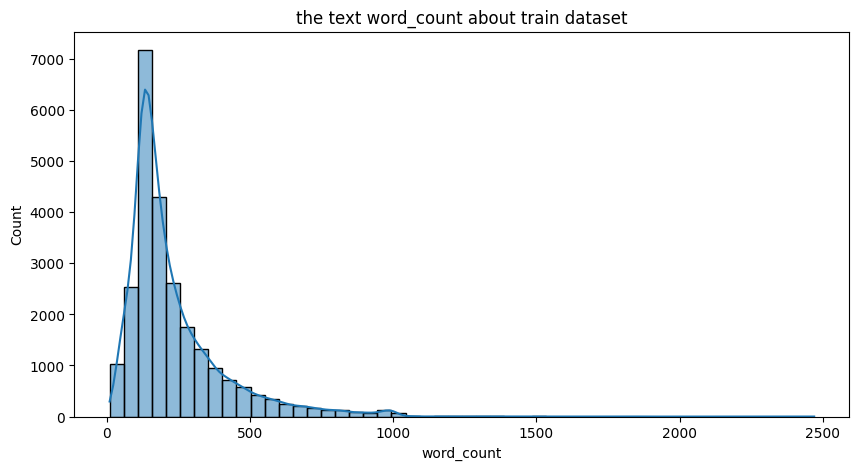

In [4]:
# 对数据进行探索性分析，了解数据的基本特征
import pandas as pd

# 将数据转换为 DataFrame
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# 查看数据基本信息
print("训练集信息:")
print(train_df.info())
print("\n测试集信息:")
print(test_df.info())

# 查看标签分布
print("\n训练集标签分布:")
print(train_df['label'].value_counts())
print("\n测试集标签分布:")
print(test_df['label'].value_counts())

# 查看文本长度分布
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

print("\n训练集文本长度统计:")
print(train_df['text_length'].describe())
print("\n测试集文本长度统计:")
print(test_df['text_length'].describe())

# 统计词数
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

# 查看词数分布
print("训练集词数统计:")
print(train_df['word_count'].describe())
print("\n测试集词数统计:")
print(test_df['word_count'].describe())

# 可视化文本长度分布
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(train_df['word_count'], bins=50, kde=True)
plt.title("the text word_count about train dataset")
plt.show()

In [5]:
# 根据训练集文本构建词汇表，将文本转换为数值表示。
from collections import Counter

# 构建词汇表
def build_vocab(texts, vocab_size=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common(vocab_size))}
    vocab['<PAD>'] = 0  # 填充符
    vocab['<UNK>'] = 1  # 未知词
    return vocab

# 只会编码出现次数最多的10000个词
vocab = build_vocab(train_texts, vocab_size=10000)
print(f"词汇表大小: {len(vocab)}")
print("示例词汇:", list(vocab.items())[:10])

词汇表大小: 10002
示例词汇: [('the', 2), ('a', 3), ('and', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('I', 9), ('that', 10), ('this', 11)]


In [6]:
# 检查有多少词汇被映射为 <UNK>
def count_unk_words(texts, vocab):
    unk_count = 0
    total_count = 0
    for text in texts:
        for word in text.split():
            total_count += 1
            if word not in vocab:
                unk_count += 1
    return unk_count, total_count

unk_count, total_count = count_unk_words(train_texts, vocab)
print(f"未知词数量: {unk_count}")
print(f"总词数: {total_count}")
print(f"未知词比例: {unk_count / total_count:.2%}")

未知词数量: 802253
总词数: 5844680
未知词比例: 13.73%


In [7]:
# 使用词汇表将文本转换为数值序列
def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

# 转换训练集和测试集
train_sequences = [text_to_sequence(text, vocab) for text in train_texts]
test_sequences = [text_to_sequence(text, vocab) for text in test_texts]

print("示例文本:", train_texts[0])
print("转换后的序列:", train_sequences[0])

示例文本: As a popular sport, surfing was liked by many people. Just after watched the documentary, I realized how dangerous it could be. In fact the surfers also scared of big waves. Even somebody got killed by it. But they still kept on surfing and enjoyed themselves. Only brave people can do it.<br /><br />According to what the surfers said, we can clearly knew what they felt when the big wave came at them. You have to adjust to your best and avoid direct strike from the big wave. When you win it, that will obviously bring you huge satisfaction.<br /><br />The amazing cinematography cannot be overlooked. That is absolutely visual enjoyment.<br /><br />An excellent sports documentary. 8/10
转换后的序列: [234, 3, 1122, 1, 6336, 14, 381, 30, 102, 1090, 560, 110, 284, 2, 4752, 9, 1769, 89, 2170, 12, 86, 1147, 134, 235, 2, 1, 87, 2003, 5, 230, 1, 397, 2159, 182, 646, 30, 114, 105, 38, 132, 743, 20, 6336, 4, 458, 2425, 1357, 3220, 91, 64, 88, 643, 13, 1, 6, 51, 2, 1, 1104, 82, 64, 692, 635, 51, 38,

In [8]:
import numpy as np

def pad_sequence(sequences, max_len, pad_value=0):
    padded = np.full((len(sequences), max_len), pad_value)
    for i, sequence in enumerate(sequences):
        if len(sequence) > max_len:
            padded[i] = sequence[:max_len]
        else:
            padded[i, :len(sequence)] = sequence
        
    return padded

# 根据前面的分布来看，300可以包含>75% 的数据
max_len = 300
train_padded = pad_sequence(train_sequences, max_len)
test_padded = pad_sequence(test_sequences, max_len)

print(f"裁剪后的序列维度：{train_padded.shape}")
print(f"序列示例：{train_padded[0]}")

裁剪后的序列维度：(25000, 300)
序列示例：[ 234    3 1122    1 6336   14  381   30  102 1090  560  110  284    2
 4752    9 1769   89 2170   12   86 1147  134  235    2    1   87 2003
    5  230    1  397 2159  182  646   30  114  105   38  132  743   20
 6336    4  458 2425 1357 3220   91   64   88  643   13    1    6   51
    2    1 1104   82   64  692  635   51   38  376   52    2  230 4434
  344   31  440  256   25    6    1    6  117  128    4 1231 1782 4633
   34    2  230    1  283   28 1290  204   10   76  577  661   28  638
    1   13   93  579  856  500   27    1  351    7  401 1072    1   13
 4511  361 2785 4634 4548    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

In [9]:
import pickle

# 词汇表, wb以二级制格式写入
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
    
with open("train_data.pkl", "wb") as f:
    pickle.dump((train_padded, train_labels), f)
    
with open("test_data.pkl", "wb") as f:
    pickle.dump((test_padded, test_labels), f)

In [10]:
# rb以二级制格式读取
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
    
with open("train_data.pkl", "rb") as f:
    train_padded, train_labels = pickle.load(f)
    
with open("test_data.pkl", "rb") as f:
    test_padded, test_labels = pickle.load(f)

### 再写数据读取器 dataloader

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)
    
train_dataset = IMDBDataset(train_padded, train_labels)
test_dataset = IMDBDataset(test_padded, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    print(f"文本batch维度：{batch[0].shape}")
    print(f"标签batch维度：{batch[1].shape}")
    break

/home/lwm/anaconda3/envs/cv2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


文本batch维度：torch.Size([32, 300])
标签batch维度：torch.Size([32])


### 构建网络结构

In [12]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidded, _) = self.lstm(embedded)
        output = self.fc(hidded.squeeze(0))
        return output
    
# 初始化模型
vocab_size = 10002
embed_dim = 300
hidden_dim = 256
num_classes = 2
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes)


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2)

loss_fn = nn.CrossEntropyLoss()

In [14]:
# 验证
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)

    predictions = []
    true_labels = []

    with torch.no_grad():
        test_bar = tqdm(val_loader, desc="验证")
        for batch_texts, batch_labels in test_bar:
            inputs = batch_texts.to(device)
            labels = batch_labels.to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(predictions, true_labels)
    return accuracy

In [15]:
# 训练
def train(model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, epochs=5):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_texts, batch_labels in progress_bar:
            inputs = batch_texts.to(device)
            labels = batch_labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} 平均损失: {avg_loss:.4f}")

        # 验证集上评估
        val_accuracy = evaluate(model, val_loader, device)
        print(f"验证集准确率: {val_accuracy:.4f}")

        # 动态调整学习率
        scheduler.step(val_accuracy)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, train_loader, optimizer, scheduler, loss_fn, device, epochs=5)

Epoch 1/5: 100%|██████████| 782/782 [00:13<00:00, 57.98it/s, loss=0.705]


Epoch 1 平均损失: 0.6942


验证: 100%|██████████| 782/782 [00:05<00:00, 153.50it/s]


验证集准确率: 0.5435


Epoch 2/5: 100%|██████████| 782/782 [00:13<00:00, 58.85it/s, loss=0.66] 


Epoch 2 平均损失: 0.6769


验证: 100%|██████████| 782/782 [00:05<00:00, 151.72it/s]


验证集准确率: 0.5835


Epoch 3/5: 100%|██████████| 782/782 [00:13<00:00, 58.94it/s, loss=0.569]


Epoch 3 平均损失: 0.5394


验证: 100%|██████████| 782/782 [00:05<00:00, 153.43it/s]


验证集准确率: 0.7963


Epoch 4/5: 100%|██████████| 782/782 [00:12<00:00, 60.68it/s, loss=0.304]


Epoch 4 平均损失: 0.3546


验证: 100%|██████████| 782/782 [00:05<00:00, 154.62it/s]


验证集准确率: 0.8974


Epoch 5/5: 100%|██████████| 782/782 [00:13<00:00, 59.98it/s, loss=0.103] 


Epoch 5 平均损失: 0.2474


验证: 100%|██████████| 782/782 [00:05<00:00, 155.91it/s]


验证集准确率: 0.9471


In [16]:
test_accuracy = evaluate(model, test_loader, device)
print(f"验证集准确率: {test_accuracy:.4f}")

验证: 100%|██████████| 782/782 [00:05<00:00, 155.31it/s]


验证集准确率: 0.8170


In [17]:
torch.save(model.state_dict(), 'text_classifier_model.pth')

In [18]:
# 初始化模型
vocab_size = 10002
embed_dim = 300
hidden_dim = 256
num_classes = 2
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes)

# 加载保存的 state_dict
model.load_state_dict(torch.load('text_classifier_model.pth'))

<All keys matched successfully>

In [19]:
test_accuracy = evaluate(model, test_loader, device)
print(f"验证集准确率: {test_accuracy:.4f}")

验证: 100%|██████████| 782/782 [00:05<00:00, 152.79it/s]

验证集准确率: 0.8170


In [20]:
def predict_onetext(text, model, vocab, device, max_len=300):
    tockens = text.split()      # 转化为单词列表
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in tockens]                # 将词转换为索引
    sequence = sequence[:max_len] + [vocab["<PAD>"]] * (max_len - len(sequence))    # 填充或截断
    sequence = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)     # 转化为张量并添加批次维度

    # print(sequence)

    # 推理
    model.eval()
    model.to(device)
    with torch.no_grad():
        output = model(sequence).cpu()
        # print(output)
        pred = torch.argmax(output, dim=1).item()
        # pred = torch.argmax(output).item()

    return "正面" if pred == 1 else "负面"

# 测试推理
text = "This movie was fantastic! I loved every minute of it."
print(f"预测结果: {predict_onetext(text, model, vocab, device)}")


预测结果: 正面


In [21]:
# 测试集上预测
def predict(model, test_loader, device):
    model.eval()
    model.to(device)

    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="测试集预测"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# 在测试集上进行预测
test_predictions, test_true_labels = predict(model, test_loader, device)

测试集预测: 100%|██████████| 782/782 [00:05<00:00, 151.86it/s]


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_predictions, test_true_labels)
precision = precision_score(test_predictions, test_true_labels, average="binary")
recall = recall_score(test_predictions, test_true_labels, average="binary")
f1 = f1_score(test_true_labels, test_predictions, average='binary')

print(f"测试集准确率: {accuracy:.4f}")
print(f"测试集精确率: {precision:.4f}")
print(f"测试集召回率: {recall:.4f}")
print(f"测试集 F1 分数: {f1:.4f}")

测试集准确率: 0.8170
测试集精确率: 0.8045
测试集召回率: 0.8252
测试集 F1 分数: 0.8147


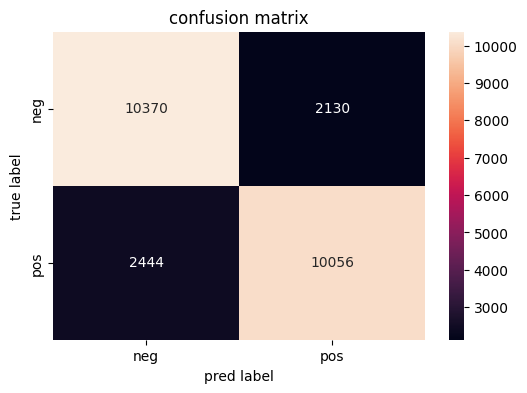

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(test_true_labels, test_predictions)

# 绘制混淆矩阵
plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.xlabel('pred label')
plt.ylabel('true label')
plt.title('confusion matrix')
plt.show()